# Image Visualization Lab

THe data set we selected is the Stanford Dogs data set from Tensorflow. It contains pictures of 120 dog breed from around the world. The purpose of collecting the data was for use in find grain image categorization. The prediction task of the data set would be to see a image of a dog and predict the dog breed based on the the visual characteristics. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from ipywidgets import fixed
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# Load the dataset
(train_ds, test_ds), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

In [2]:
# resize images and convert dataset to numpy arrays
def dataset_to_numpy(dataset, img_size=(224, 224)):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        image = tf.image.resize(image, img_size).numpy()
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = dataset_to_numpy(train_ds)
test_images, test_labels = dataset_to_numpy(test_ds)

# Linearize the images to create a table of 1-D image features
train_images_flat = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2] * train_images.shape[3])
test_images_flat = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2] * test_images.shape[3])

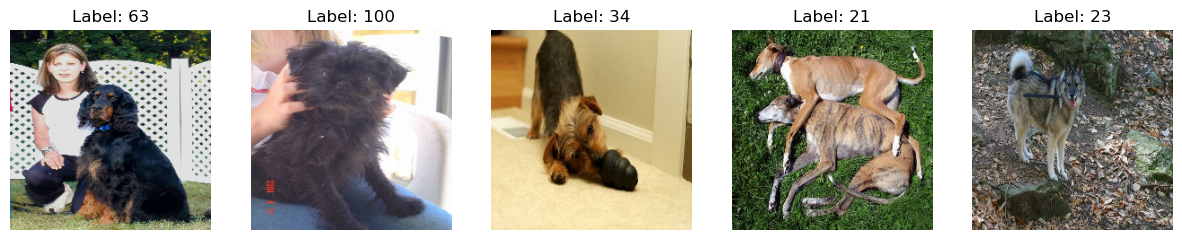

In [3]:
# Display some images from the training dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i].astype("uint8"))
    ax.set_title(f"Label: {train_labels[i]}")
    ax.axis('off')
plt.show()



In [4]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, train_images.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(train_images_flat.copy())


Extracting the top 300 eigenfaces from 12000 faces
CPU times: total: 4min 23s
Wall time: 2min 33s


PCA(n_components=300)

In [5]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

plot_explained_variance(pca)

# Feature Extraction

c:\Users\mmthe_22\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



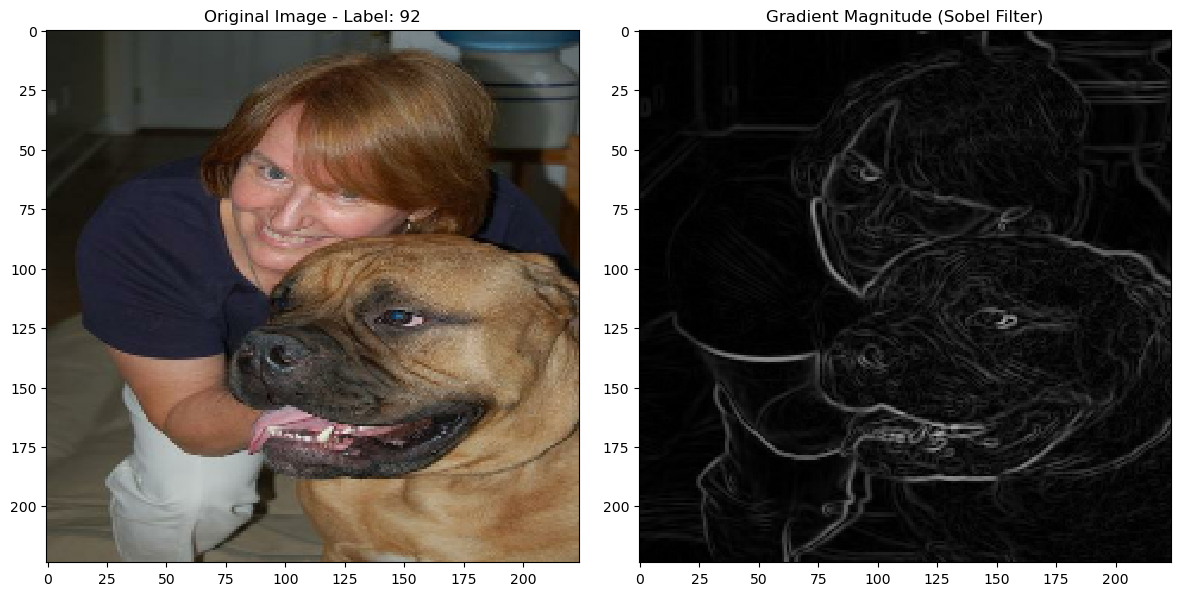

In [6]:
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v

plt.figure(figsize=(12, 6))

idx_to_reconstruct = np.random.randint(len(train_images))

plt.subplot(1, 2, 1)
img = train_images[idx_to_reconstruct].astype('uint8')
imshow(img)
plt.title(f"Original Image - Label: {train_labels[idx_to_reconstruct]}")
plt.grid(False)

plt.subplot(1, 2, 2)
gradient_mag = np.sqrt(sobel_v(img[:, :, 0])**2 + sobel_h(img[:, :, 0])**2)  # Using only one color channel (Red)
imshow(gradient_mag, cmap='gray')
plt.title("Gradient Magnitude (Sobel Filter)")
plt.grid(False)

plt.show()

## Daisy


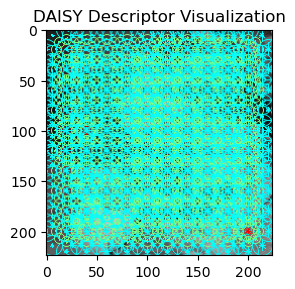

In [7]:
from skimage.feature import daisy
from skimage.color import rgb2gray

img_gray = rgb2gray(img)
features, img_desc = daisy(img_gray, 
                           step=20, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
plt.subplot(1, 2, 2)
plt.imshow(img_desc)
plt.title("DAISY Descriptor Visualization")
plt.grid(False)

In [14]:
import time

features = daisy(img_gray, step=10, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

def apply_daisy(row, shape):
    gray_image = rgb2gray(row)  # Convert image to grayscale
    feat = daisy(gray_image, step=10, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)  # DAISY with different parameters
    return feat.reshape((-1))

h, w, c = train_images[0].shape

start_time = time.time()
test_feature = apply_daisy(train_images[3], (h, w))
end_time = time.time() 
print(end_time-start_time)
print(test_feature.shape)

daisy_features = np.array([apply_daisy(img, (h, w)) for img in train_images])
print(daisy_features.shape)


(19, 19, 68)
24548
0.036705970764160156
(24548,)
(12000, 24548)


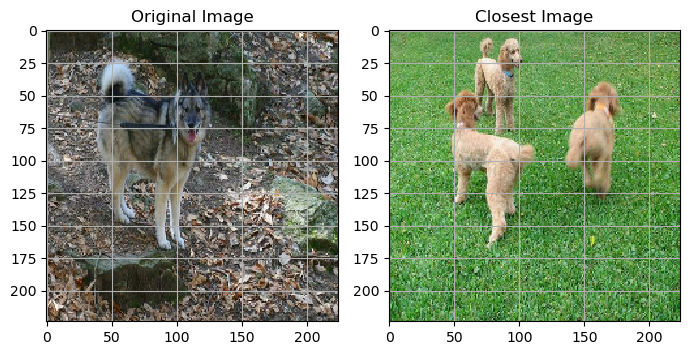

In [18]:
from sklearn.metrics.pairwise import pairwise_distances
dist_matrix = pairwise_distances(daisy_features)
idx1 = 4
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(train_images[idx1].astype("uint8"))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(train_images[idx2].astype("uint8"))
plt.title("Closest Image")
plt.grid()

The above shows the closest image to images in our data set using the daisy image extraction. From trying with differtent images it seems that Daisy is not a suitable fit for our data set as the images it saying are closest are not images of dogs of smilar dog breeds. 